<Axes: xlabel='Date_Symptoms'>

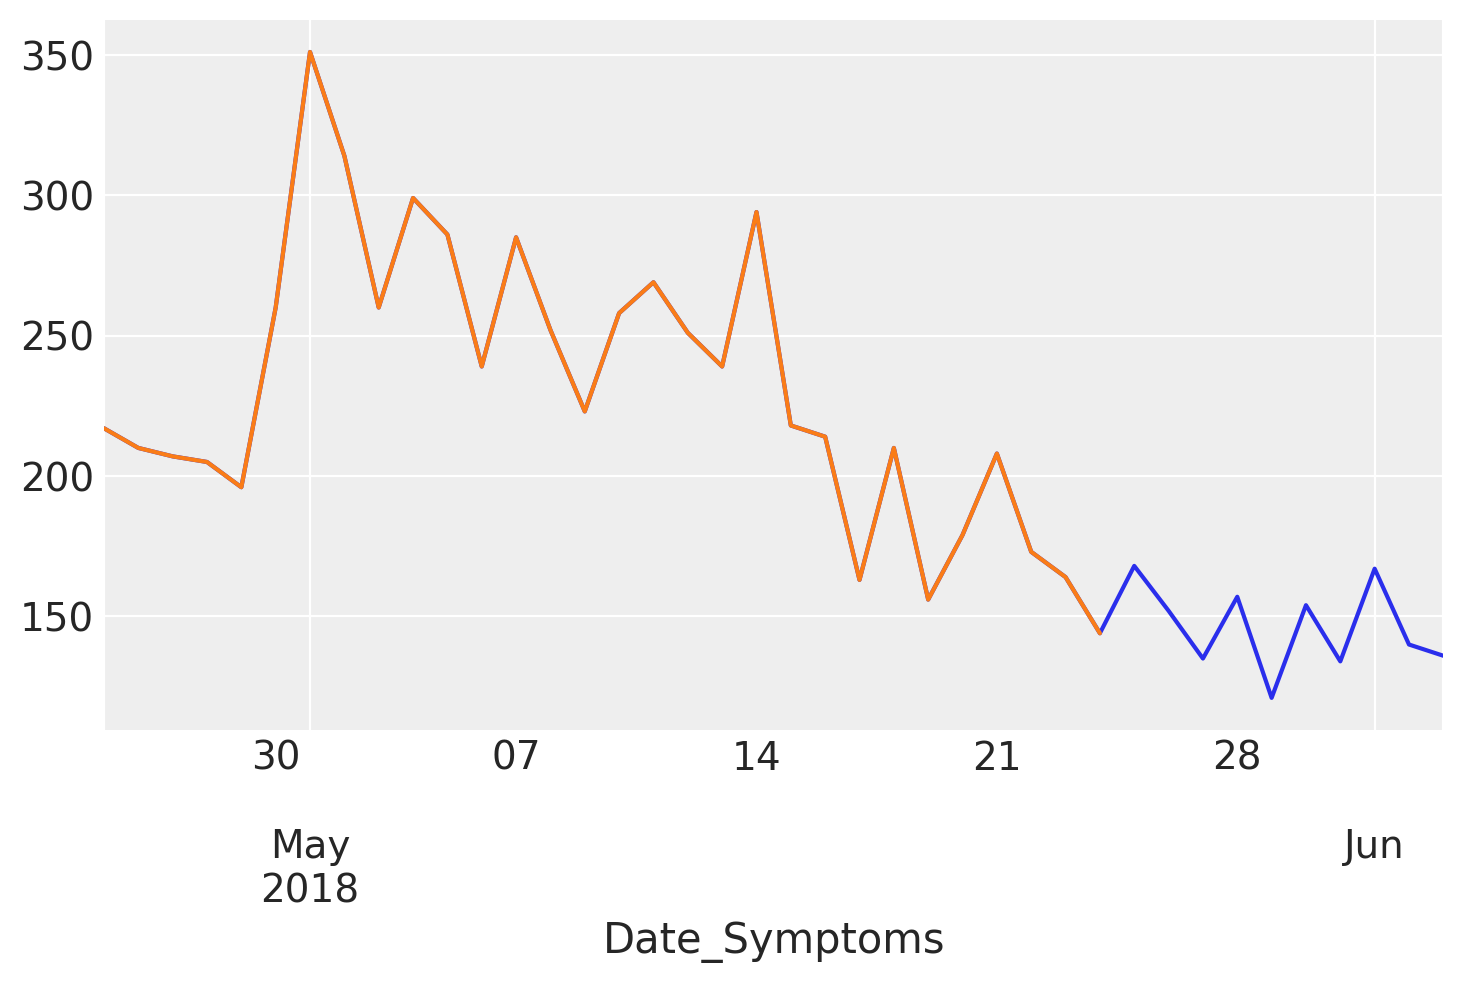

In [250]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def sampler_kwargs():
    return dict(
        nuts_sampler="nutpie",
        chains=2,
        draws=300,
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"},
    )

project_dir = Path.cwd().parent
train_df = pd.read_csv(project_dir / "data" / "model" / "training_data.csv",
    parse_dates=True,
    date_format="%Y %b",
    index_col=0,
    dtype={"value": float},
)

start_index = 1900
M = 30
D = 10

y = train_df.sum(axis=1)[start_index: start_index + M + D]
y.index = pd.to_datetime(y.index)
y.index.freq = y.index.inferred_freq

y_train = y[:-D]
y.plot()
y_train.plot()

In [251]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

In [252]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 8998
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-darkgrid")

In [253]:
n = len(y_train)  # The number of data points
X = np.array(list(range(0,n))).reshape(-1,1)


X_min = np.min(X)
X_max = np.max(X)
X_scaled = (X - X_min) / (X_max - X_min)

X_new = np.array(list(range(n+1,n+D+1))).reshape(-1,1)
X_new_scaled = (X_new - X_min) / (X_max - X_min)
X_new_scaled

array([[1.06896552],
       [1.10344828],
       [1.13793103],
       [1.17241379],
       [1.20689655],
       [1.24137931],
       [1.27586207],
       [1.31034483],
       [1.34482759],
       [1.37931034]])

In [254]:
with pm.Model() as model:

    # Linear trend parameters
    b0 = pm.Normal("b0", mu=0, sigma=10)   # intercept
    b1 = pm.Normal("b1", mu=0, sigma=10)   # slope

    ell_trend = pm.Gamma("ell_trend", alpha=5, beta=1)   # length scale
    eta_trend = pm.HalfNormal("eta_trend", sigma=0.5)      # amplitude
    cov_trend = eta_trend**2 * pm.gp.cov.ExpQuad(1, ls=ell_trend)

    mean_func = pm.gp.mean.Linear(coeffs=0, intercept=0)

    # Periodic kernel parameters
    period = pm.Gamma("period", alpha=2, beta=6)
    ell_per = pm.Gamma("ell_per", alpha=5, beta=5)   # length scale
    eta_per = pm.HalfNormal("eta_per", sigma=15)      # amplitude
    cov_per = eta_per**2 * pm.gp.cov.Periodic(1, period=period, ls=ell_per)

    sigma_noise = pm.HalfNormal("sigma_noise", sigma=2)
    cov_noise = pm.gp.cov.WhiteNoise(sigma_noise**2)

    cov = cov_trend + cov_per + cov_noise

    

    gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov)

    f = gp.prior("f", X=X_scaled)

    log_lam = f
    lam = pm.Deterministic("lam", pm.math.exp(log_lam))

    y_ = pm.Poisson("y", mu=lam, observed=y_train)

    idata = pm.sample(**sampler_kwargs())


/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/NowcastingVenv/lib/python3.12/site-packages/pymc/model/fgraph.py:163: UserWarning: Detected variables likely created by GP objects. Further use of these old GP objects should be avoided as it may reintroduce variables from the old model. See issue: https://github.com/pymc-devs/pymc/issues/6883
  warnings.warn(


Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,29,0.07,127
,1300,267,0.07,4


In [255]:

with model:
    # add the GP conditional to the model, given the new X values
    f_pred = gp.conditional("f_pred", X_new_scaled, jitter=1e-6)

    # Predict log(lambda) = f_pred
    log_lam_pred = f_pred
    lam_pred = pm.Deterministic("lam_pred", pm.math.exp(log_lam_pred))

    ppc = pm.sample_posterior_predictive(idata, var_names=["lam_pred"], random_seed=42)

Sampling: [f_pred]


Output()

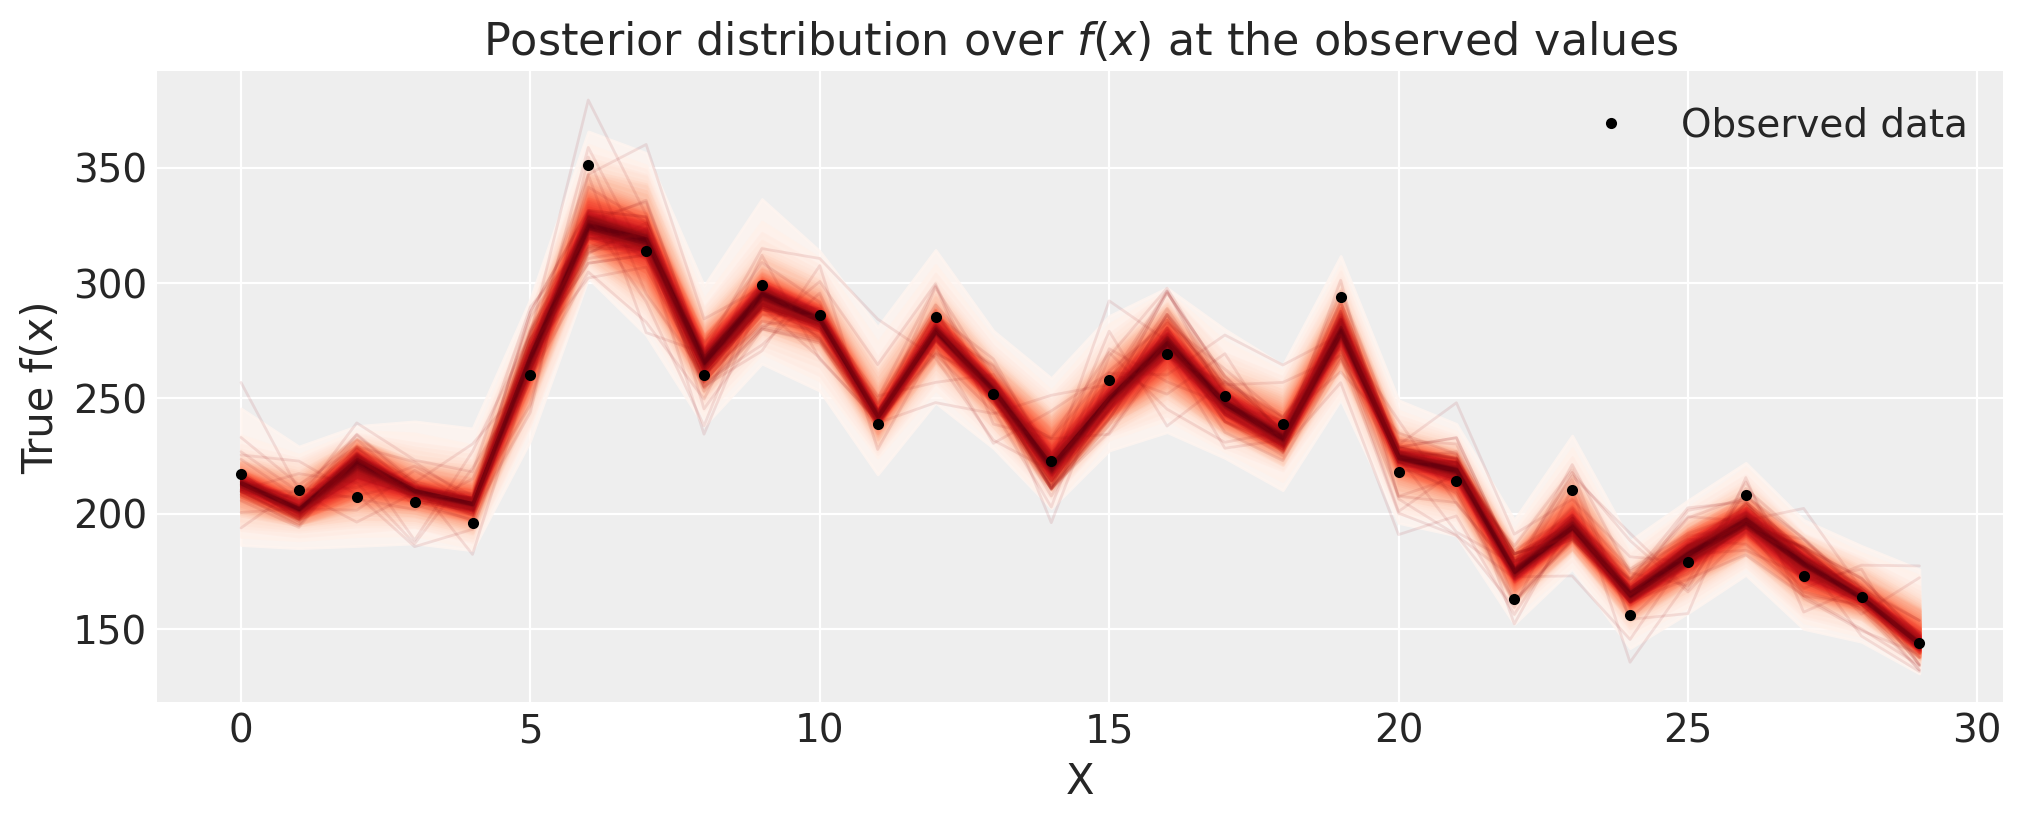

In [256]:
# plot the results
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc.gp.util import plot_gp_dist

lam_post = az.extract(idata, var_names="lam").transpose("sample", ...)
plot_gp_dist(ax, lam_post, X)

ax.plot(X, y_train, "ok", ms=3, label="Observed data")

# axis labels and title
plt.xlabel("X")
plt.ylabel("True f(x)")
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend()

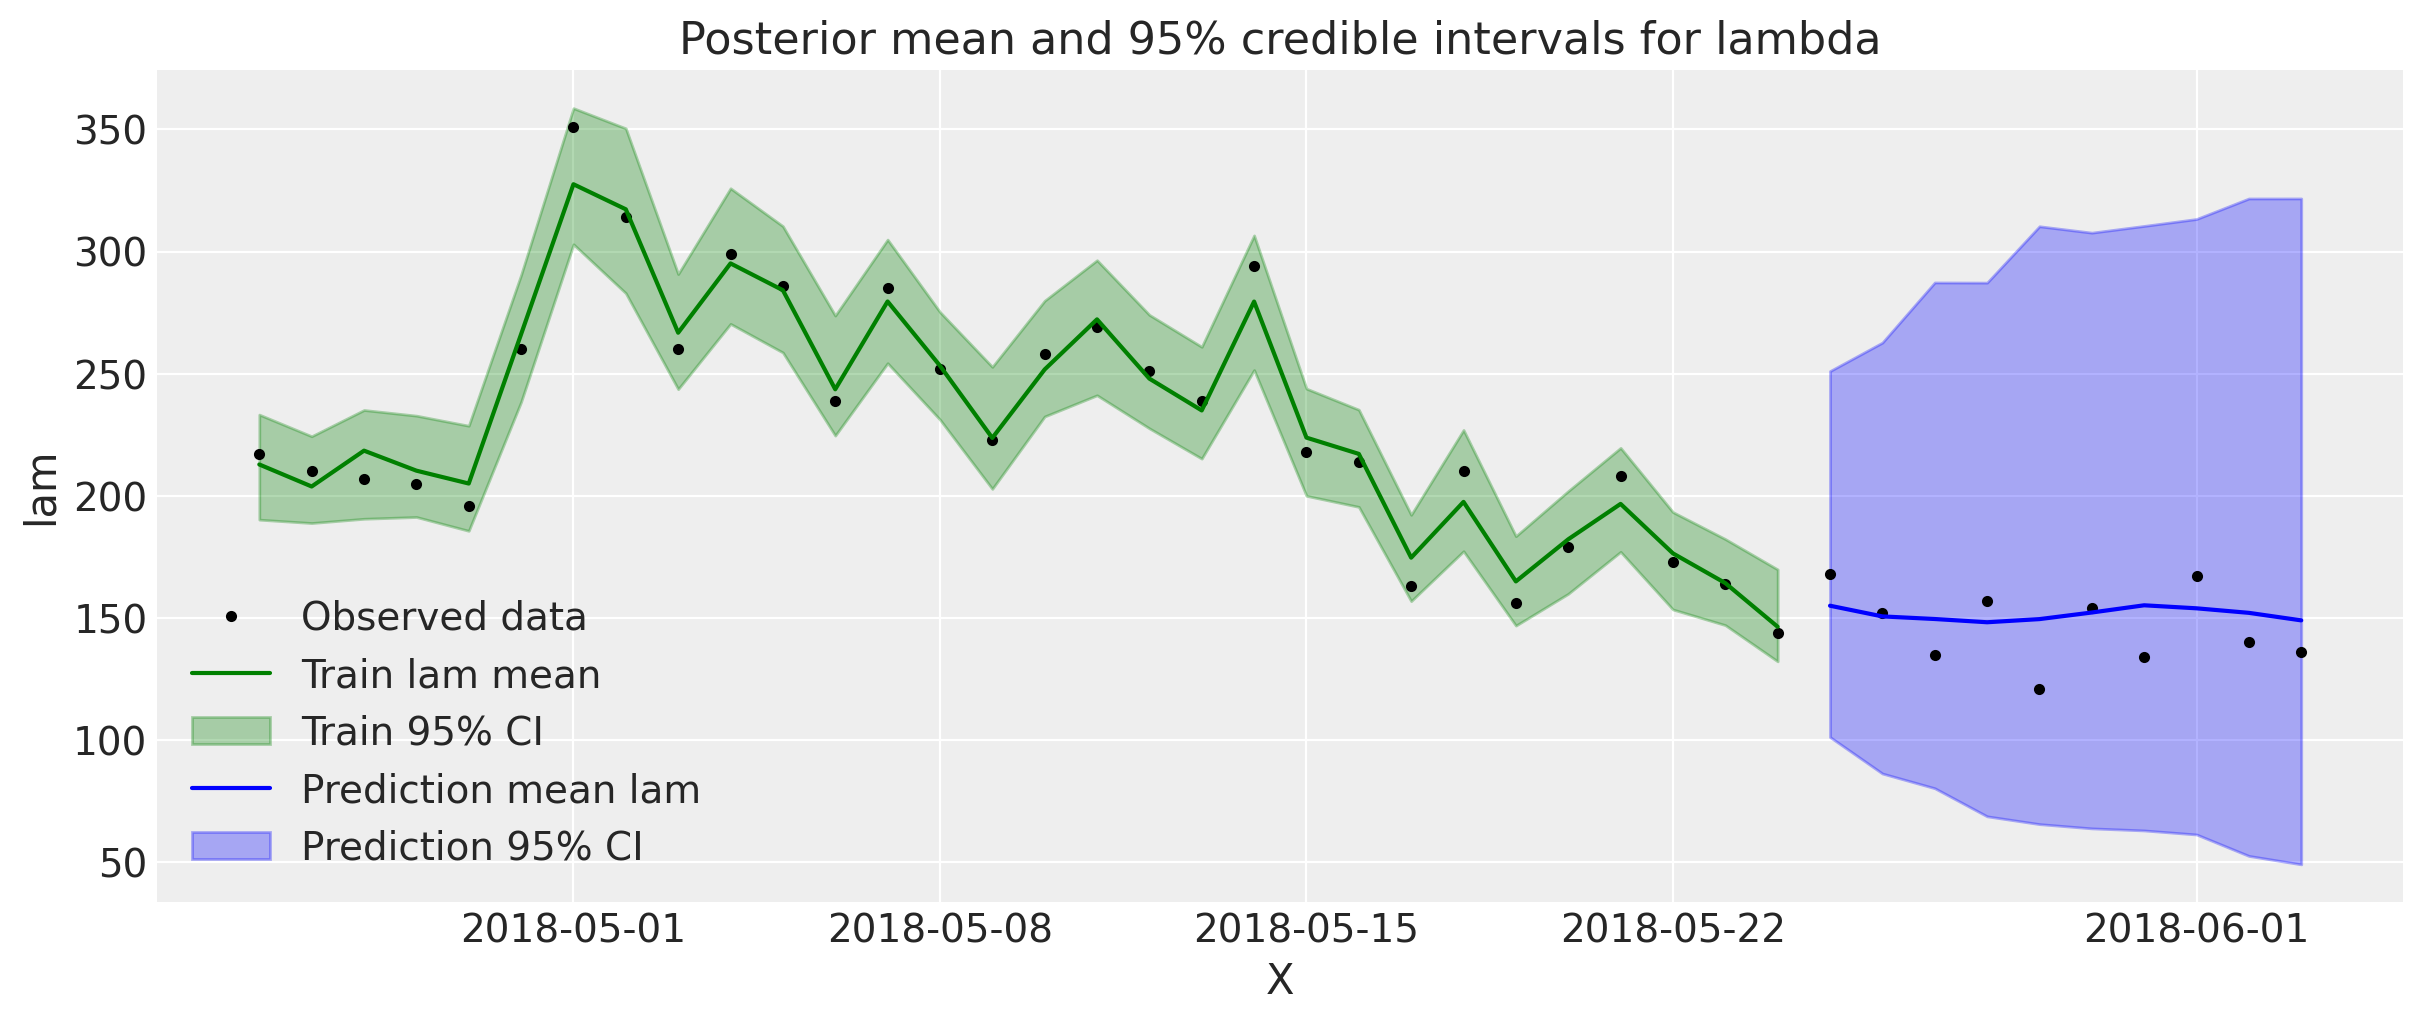

In [257]:
import matplotlib.pyplot as plt
import numpy as np



fig, ax = plt.subplots(figsize=(12, 5))

# Observed data points
ax.plot(y.index, y, 'ok', ms=3, label="Observed data")

# 1. Training lambda CI
lam_train_samples = idata.posterior["lam"].stack(draws=("chain", "draw")).values
mean_train = lam_train_samples.mean(axis=1)
lower_train = np.percentile(lam_train_samples, 2.5, axis=1)
upper_train = np.percentile(lam_train_samples, 97.5, axis=1)

# Plot CI for training data
ax.plot(y_train.index, mean_train, color='green', label="Train lam mean")
ax.fill_between(y_train.index, lower_train, upper_train, color='green', alpha=0.3, label='Train 95% CI')

# 2. Prediction lambda CI
lam_pred_samples = ppc.posterior_predictive["lam_pred"].stack(draws=("chain", "draw")).values
mean_pred = lam_pred_samples.mean(axis=1)
lower_pred = np.percentile(lam_pred_samples, 2.5, axis=1)
upper_pred = np.percentile(lam_pred_samples, 97.5, axis=1)

# Plot CI for predictions (assumes y[-10:].index corresponds to X_new)
ax.plot(y[-D:].index, mean_pred, color='blue', label="Prediction mean lam")
ax.fill_between(y[-D:].index, lower_pred, upper_pred, color='blue', alpha=0.3, label='Prediction 95% CI')

# Labels and legend
ax.set_xlabel("X")
ax.set_ylabel("lam")
ax.set_title("Posterior mean and 95% credible intervals for lambda")
ax.legend()

plt.show()
